# Objective

- Demonstration of analysis perfomed on mined logical rules to explain "Lung Cancer" treatments
- In this notebook, 
    - Identifying how semantics of Knowledge Graphs (KGs) impact on the quality of mined logical rules
    - Loading the pre-mined logical rules
    - SQL queries to analyze rules based on the PCA Confidence metrics
    - Discovering patterns of distribution of 'Head' of the rules

<div class="alert alert-block alert-info">
<b>Note:</b> The Knowledge Graph used to perform the analysis is from an EraMed project 'P4-LUCAT' and contains information about lung cancer patients which cannot be made public. Therefore, only the logical rules mined over the KG is made available to be analyzed and processed.
</div>

<div class="alert alert-block alert-warning">
Rule mining is the technique to discovering meaningful patterns in the form of rules from large collections of background knowledge. <br>
    <b>Example:</b> Logical Rules are of the form <b> Body </b> &rarr; <b> Head </b>. 
</div>

## Imports and Parameter Definition

### Libraries Import

In [ ]:
import rdflib
from rdflib import Literal, Graph
from rdflib.namespace import RDF, RDFS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from pandasql import sqldf

### Visual of the 'Lung cancer' patient KG used as benchmark

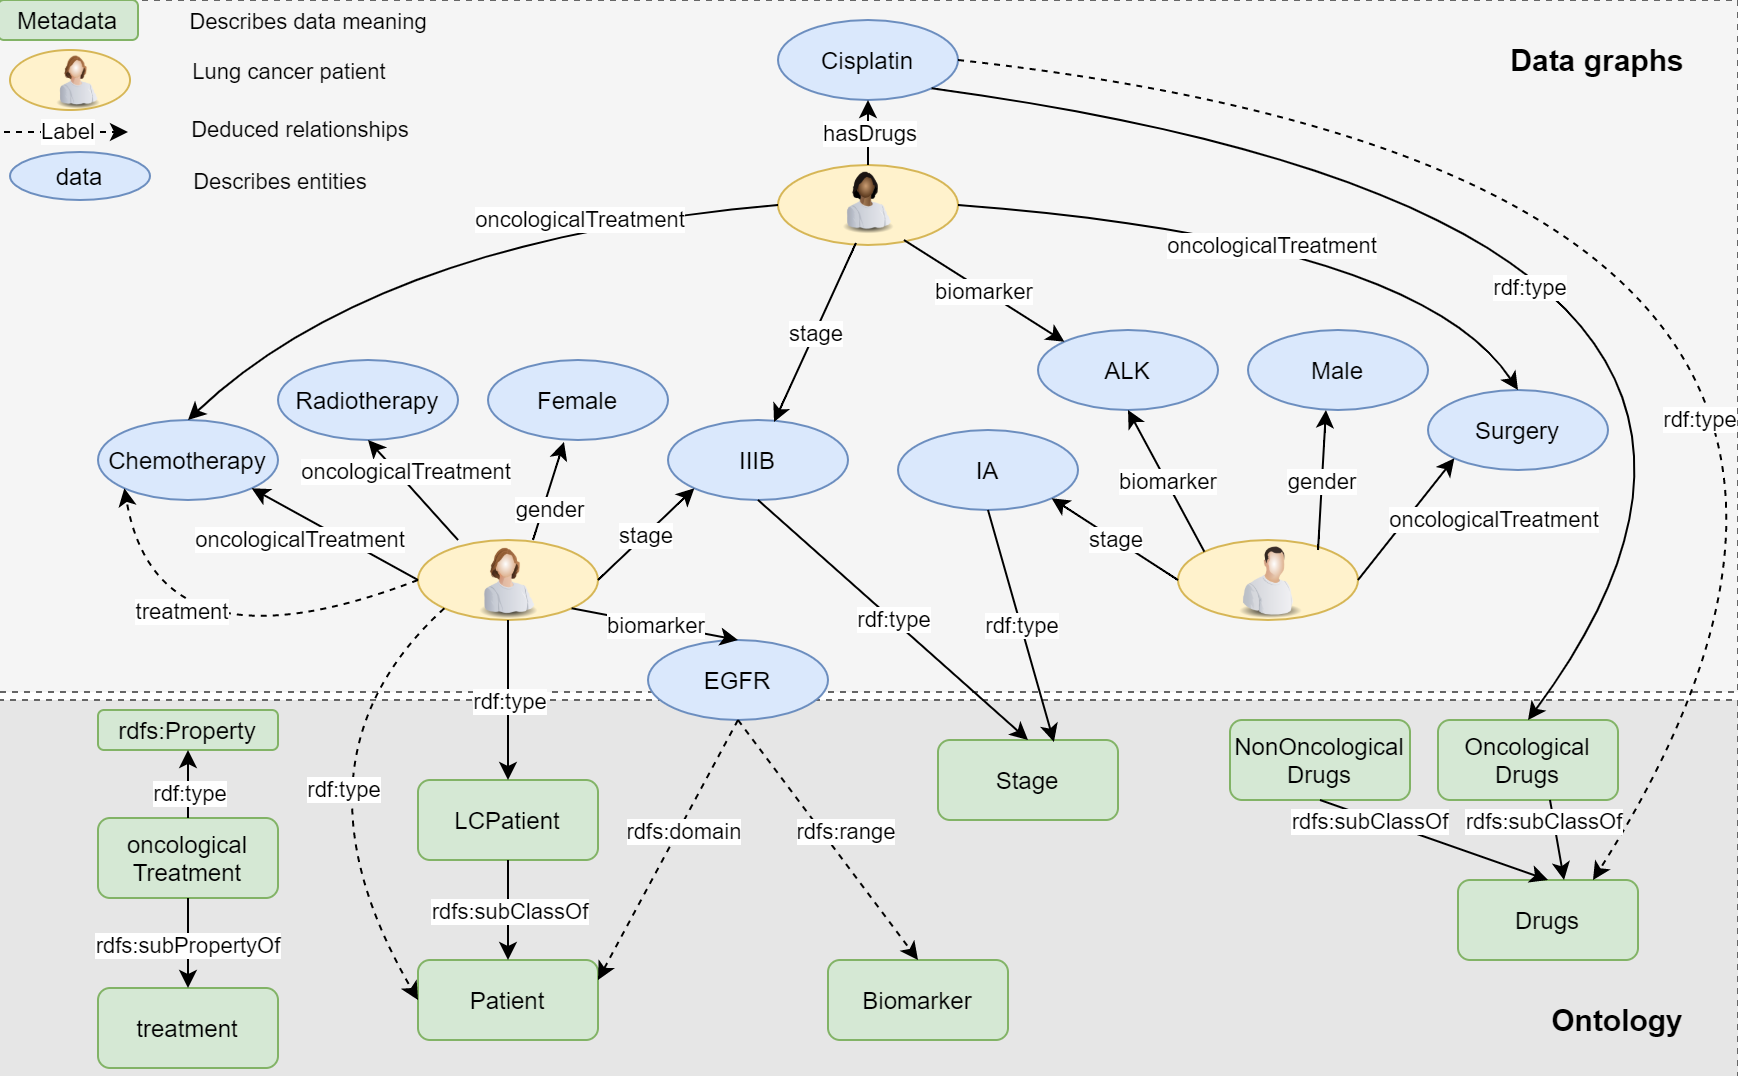

# Analysis to demonstrate the usage of entailment regimes and inference over Knowledge Graphs

### Study aims at reporting the impact of injecting entailment regimes on the KGs

Enriching the mined rule aids in the extraction of new insights from the KGs. In contrast to naive approaches, our approach takes **rdfs:subPropertyOf** into account for the experiments in the current example. This yields higher metrics values and demonstrates potential true predictions. For example, higher *Inferred PCA Confidence* of a rule quantifies the KG's partial completion by identifying more productive rules.

- A small subset of the KG is used to demonstrate this example. Load the rules with added metrics computed on the KGs by injecting the above mentioned entailment regime to observe the difference in metrics value and compare the results 

In [ ]:
inferred_df = pd.read_csv("Rules/phd_experiments_result.csv")
inferred_df[['Body','Head','Positive_Examples','Head_Coverage','PCA_Confidence','Inferred_Support','Inferred_Confidence','Inferred_PCA']]

### Understanding the distribution of the PCA Confidence metric over KGs on how frequently each value occurs.

In [ ]:
def p_value(inferred_df):
    p_val = pearsonr(inferred_df['PCA_Confidence'], inferred_df['Inferred_PCA'])[1]
    return p_val    

In [ ]:
def histogram(inferred_df):
    p = p_value(inferred_df)
    fig = plt.figure(figsize=(15,8))
    plt.suptitle("Pearson correlation coefficient and p-value for testing non-correlation with p-value: {}".format(p),fontsize=15)
    ax1 = fig.add_subplot(121)
    ax1.hist(inferred_df['PCA_Confidence'], bins=20, alpha=0.5)
    # ax1.set_yscale('symlog')
    ax1.set_yscale('linear')
    ax1.set_title('PCA Confidence')
    ax1.set_xlabel('PCA Confidence')
    ax1.set_ylabel('Rules')
    ax2 = fig.add_subplot(122)
    ax2.hist(inferred_df['Inferred_PCA'], bins=20, alpha=0.5)
    ax2.set_yscale('linear')
    ax2.set_title('Inferred PCA Confidence')
    ax2.set_xlabel('Inferred PCA Confidence')
    ax2.set_ylabel('Rules')
    plt.savefig('Plots/Distribution_of_PCA_Confidence.png')
    plt.show()

### P Value and Histrogram are plotted to illustrate the usage of semantics in rule mining system

In [ ]:
histogram(inferred_df)

# Analysis to demonstrate the exploration of mined rules

### Importing the rules mined over clinical data

 The rules are mined and can be found in the *.CSV* format under the folder of *Rules*. They can be loaded in a dataframe for further analysis
 

In [ ]:
df = pd.read_csv("Rules/rules_clinical_data.csv")
df

## Analysis using SQL queries

Grouping by Head
   - **MIN()** - minimum *PCA Confidence* score for each Head of the rule.
   - **MAX()** - maximum *PCA Confidence* score for each Head of the rule.
   - **AVG()** - average *PCA Confidence* score for each Head of the rule.

In [ ]:
query = f"""SELECT DISTINCT Head, MIN(PCA_Confidence), MAX(PCA_Confidence), AVG(PCA_Confidence) FROM df GROUP BY Head"""

For example, 
- Head **hasOncologicalTreatment-Chemotherapy** has many instances therefore, 
    - the *MAX(PCA_Confidence)* is 1, 
    - *MIN(PCA_Confidence)* is 0.37 and 
    - *AVG(PCA_Confidence)* is 0.89. 

In [ ]:
lst = sqldf(query, globals())
lst

# Distribution of PCA for Definitions of Stages

### A violin plot depicts distributions of numeric data for one or more groups using density curves. 
For example, The majority of the treatments are prescribed for the patients in **Stage IIIA** <br>
- Stage IIIA has 39 rules (more definitions as compared to other stages)
    - Highest values of PCA (i.e., 0.67)

<div class="alert alert-block alert-success">
<b>Example1:</b> hasOncologicalTreatment(Lymph_node_excision, X), hasOncologicalTreatment(Adjuvant, X) &rarr; hasStage(IIIA, X) with PCA: 0.67 <br>
There are 27 patients who have adjuvant treatments and lymph node excision surgery. There are 242 patients in Stage IIIA.
18 out of 27 patients who have adjuvant treatments and lymph node excision surgery are in Stage IIIA. <br>
    
<b>Example2:</b> hasBio(PDL1,X):- hasStage(IIIA, X) with PCA 0.11 <br>
There are 140 patients who are positive for PDL1. There are 242 patients in Stage IIIA.
16 out of 140 patients who are Positive for PDL1 are in Stage IIIA.
</div>

In [ ]:
def violinStage(stage):
    stage['Head'] = stage['Head'].apply(lambda x: x.replace('?a  <hasStage>',''))
    plt.figure(figsize=(15,8))
    sns.violinplot(x='Head', y='PCA_Confidence', data=stage, color="0.6")
    sns.stripplot(x='Head', y='PCA_Confidence', data=stage, jitter=True)
    plt.title('Stages with the distribution of PCA Confidence')
    plt.savefig('ViolinPlot/ViolinPlot-stages.png')
    plt.show()
stage = pd.read_csv("ViolinPlot/stages.csv")
violinStage(stage)

# Distribution of PCA for Definitions of Treatments 

For example, the majority of patients are treated with **Chemotherapy** treatment.
- There are 35 rules with *Chemotherapy* in Head.
    - Highest value of PCA (i.e., 1.0)

<div class="alert alert-block alert-success">
<b>Example1:</b> hasBio(PDL1, X), hasOncologicalTreatment(Immunotherapy, X)  &rarr; hasOncologicalTreatment(Chemotherapy, X)  with PCA: 1.0 <br>
There are 73 patients who are positive for PDL1 and receive immunotherapy. There are 962 patients who receive Chemotherapy.
73 out of 73 patients who are positive for PDL1 and receive immunotherapy, also receive Chemotherapy. <br>
    
<b>Example2:</b> hasStage(IB,X) &rarr; hasOncologicalTreatment(Chemotherapy, X) with PCA 0.37 <br>
There are 95 patients who are in stage IB.
962 patients who receive Chemotherapy.
36 out of 95 patients who are in Stage IB and receive Chemotherapy.
</div>

In [ ]:
def violinTreatment(treatment):
    treatment['Head'] = treatment['Head'].apply(lambda x: x.replace('?a  <hasOncologicalTreatment>',''))
    plt.figure(figsize=(15,8))
    sns.violinplot(x='Head', y='PCA_Confidence', data=treatment, color="0.6")
    sns.stripplot(x='Head', y='PCA_Confidence', data=treatment, jitter=True)
    plt.title('Oncological Treatments with the distribution of PCA Confidence')
    plt.savefig('ViolinPlot/ViolinPlot-treatments.png')
    plt.show()    
treatment = pd.read_csv("ViolinPlot/treatments.csv")
violinTreatment(treatment)

# Distribution of PCA for Definitions of Surgery 

For example, the majority of patients are treated with **Lobectomy** surgery.
- There are 35 rules with *Chemotherapy* in Head.
    - Highest value of PCA (i.e., 1.0)

<div class="alert alert-block alert-success">
<b>Example1:</b> hasStage(IB, X) hasOncologicalTreatment(Chemotherapy, X) &rarr;  hasOncologicalSurgery(Lobectomy, X) with PCA: 1.0<br>
There are 36 patients who are in stage IB and receive Chemotherapy. There are 449 patients who receive Lobectomy.
36 out of 36 patients who in stage IB and receive Chemotherapy have Lobectomy. <br>
This is consistent with the guidelines.<br>
    
<b>Example2:</b> hasStage(IV,X) &rarr; hasOncologicalSurgery(Lobectomy, X) with PCA 0.35 <br>
There are 287 patients in stage IV. There are 449 patients who receive Lobectomy.
23 out of 287 patients who are 
in Stage IV and have Lobectomy. <br>
This may be an error!
</div>

In [ ]:
def violinSurgery(surgery):
    surgery['Head'] = surgery['Head'].apply(lambda x: x.replace('?a  <hasOncologicalSurgery>',''))
    plt.figure(figsize=(15,8))
    sns.violinplot(x='Head', y='PCA_Confidence', data=surgery, color="0.6")
    sns.stripplot(x='Head', y='PCA_Confidence', data=surgery, jitter=True)
    plt.title('Oncological Surgery with the distribution of PCA Confidence')
    plt.savefig('ViolinPlot/ViolinPlot-surgery.png')
    plt.show()    
surgery = pd.read_csv("ViolinPlot/surgery.csv")
violinSurgery(surgery)